# Binary image analysis

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["figure.facecolor"]=(1,1,1,1)

## Preprocessing

Sometimes input images may contain noise that makes segmentation challenging. In such cases it is beneficial to first filter the image to reduce the effect of the noise. 

In the following example we first degradate the image by adding random noise with normal distribution ($\sigma = 10$). Notice that we also limit the range of resulting pixel values between $[0, 255]$ and convert the image to 8-bit unsigned integers.  

In [3]:
img = cv2.imread('images/smarties.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(-0.5, 412.5, 355.5, -0.5)

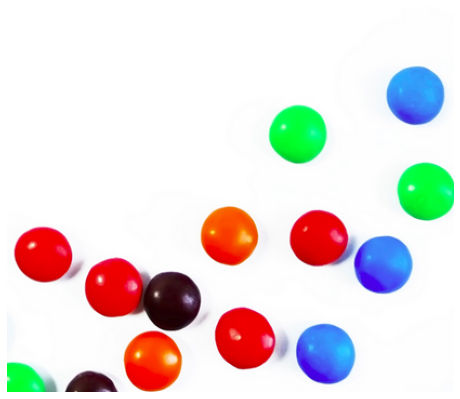

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')

In [5]:
noisy = (img+np.random.standard_normal(img.shape)*10).clip(0,255).astype(np.uint8)

(-0.5, 412.5, 355.5, -0.5)

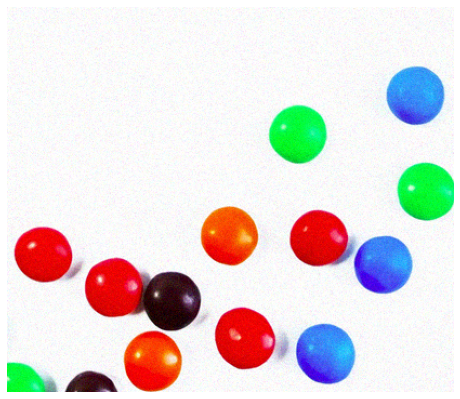

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(noisy)
plt.axis('off')

Then we use bilateral filtering to denoise the image. While conventional linear filtering methods such as Gaussian and box filters tend to smooth the image, this method has the property of preseving edges and details.

In [7]:
filtered = cv2.bilateralFilter(noisy,9,30,30)

(-0.5, 412.5, 355.5, -0.5)

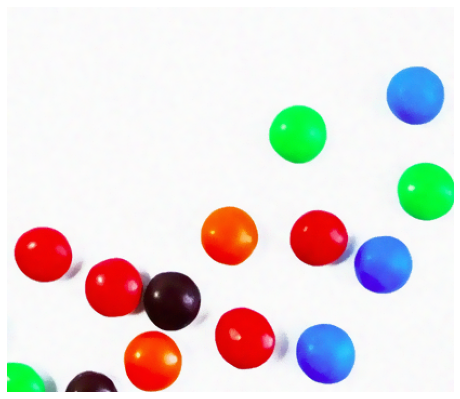

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(filtered)
plt.axis('off')

## Edge detection

Edge detection is typically used to find object boundaries where the intensity contrast is high. Next we convert the image to grayscale and try to find the boundaries of the candies using Canny edge detector that is a standard approach for edge detection.

In [9]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [10]:
edge = cv2.Canny(gray, 50, 100)

(-0.5, 412.5, 355.5, -0.5)

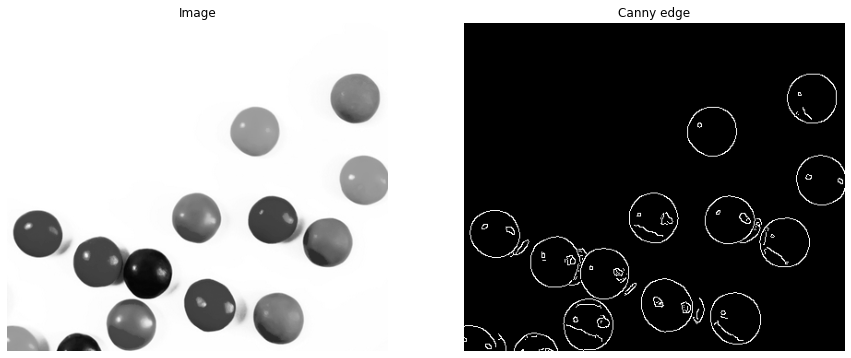

In [11]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(edge, cmap='gray')
plt.title('Canny edge')
plt.axis('off')

As we can see, the edges obtained are fragmented to smaller segments and there are also false edges due to specular reflections. In general, edge detection is sensitive to noise and other degradations, and it often does not provide continuous edges without some postprocessing. Therefore, edge detection is rarely used to segment an image to objects.

## Thresholding

Thresholding is another simple approach for image segmentation. It works well if the objects have smooth coloring. The main challenge is then to find a suitable threshold value. In the following example, we have experimentally selected the threshold to be 180.

In [12]:
ret,thresh = cv2.threshold(gray,180,255,cv2.THRESH_BINARY_INV)

(-0.5, 412.5, 355.5, -0.5)

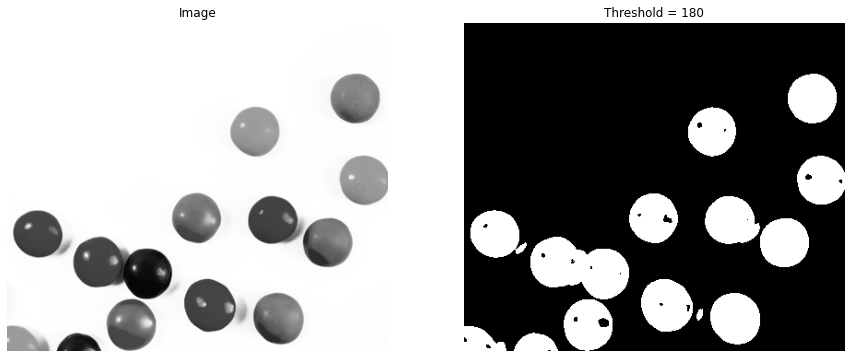

In [13]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(thresh, cmap='gray')
plt.title('Threshold = 180')
plt.axis('off')

Usually, it is necessary to select the threshold value automatically. Otsu's method is one of the best-known methods for image thresholding. It uses the histogram to compute an optimal threshold. Next, we apply it for thresholding two sample images. We also show the corresponding histograms.

In [14]:
img2 = cv2.imread('images/splash.tiff')
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3 = cv2.imread('images/stuff.jpg')
gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

In [15]:
ret2, otsu2 = cv2.threshold(gray2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3, otsu3 = cv2.threshold(gray3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [16]:
img4 = cv2.imread('images/sudoku.png')
gray4 = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)

(-0.5, 639.5, 479.5, -0.5)

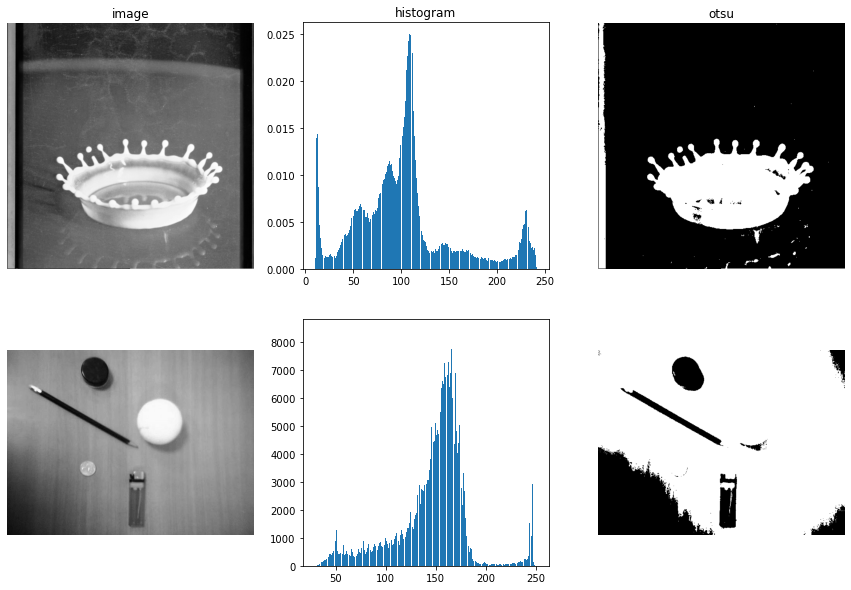

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.title('image')
plt.imshow(gray2, cmap='gray')
plt.axis('off')
plt.subplot(232)
plt.title('histogram')
h2 = plt.hist(gray2.ravel(),256, density=True)
plt.subplot(233)
plt.title('otsu')
plt.imshow(otsu2, cmap='gray')
plt.axis('off')
plt.subplot(234)
plt.imshow(gray3, cmap='gray')
plt.axis('off')
plt.subplot(235)
h3 = plt.hist(gray3.ravel(),256)
plt.subplot(236)
plt.imshow(otsu3, cmap='gray')
plt.axis('off')

As we can see, thresholding fails if the background is not uniform enough. In adaptive thresholding the threshold is calculated locally. Let's see how it works with the following two images.

In [18]:
th3 = cv2.adaptiveThreshold(gray3,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,21,2)
th4 = cv2.adaptiveThreshold(gray4,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,21,2)

(-0.5, 557.5, 562.5, -0.5)

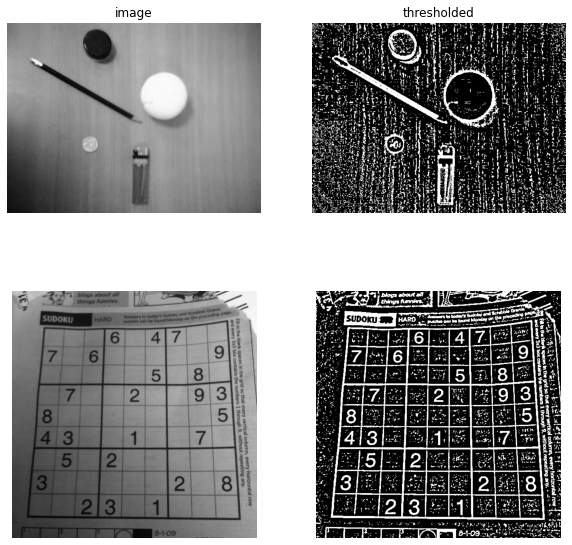

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('image')
plt.imshow(gray3, cmap='gray')
plt.axis('off')
plt.subplot(222)
plt.title('thresholded')
plt.imshow(th3, cmap='gray')
plt.axis('off')
plt.subplot(223)
plt.imshow(gray4, cmap='gray')
plt.axis('off')
plt.subplot(224)
plt.imshow(th4, cmap='gray')
plt.axis('off')

The result appears to be very noisy. Segmenting the objects from the background may require further preprocessing and postprocessing.

## Color segmentation

Next, we convert the previous image to normalized rgb space to perform color segmentation. In this way, we try to minimize the effect of non-uniform lighting.

In [20]:
r, g, b = cv2.split(img3.astype(np.float32))
I = r + g + b
r, g, b = (r, g, b)/I
img3n = cv2.merge((r, g, b))

(-0.5, 639.5, 479.5, -0.5)

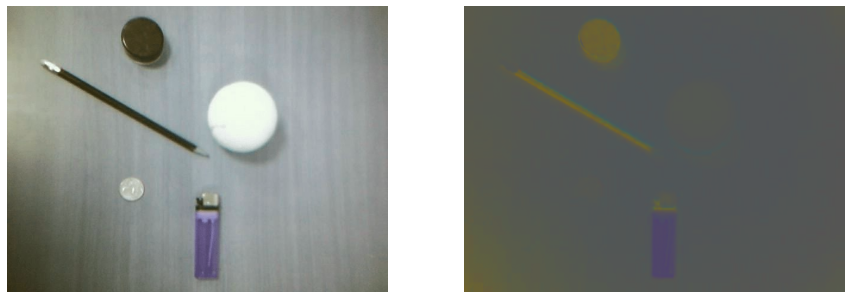

In [21]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img3)
plt.axis('off')
plt.subplot(122)
plt.imshow(img3n)
plt.axis('off')

To find the color clusters, we subsample the image and create a scatter plot of the colors.

In [22]:
ds = cv2.resize(img3n, (50,50))
rs, gs, bs = cv2.split(ds)
rs, gs, bs = (rs.ravel(), gs.ravel(), bs.ravel())
color = np.array((rs, gs, bs)).T

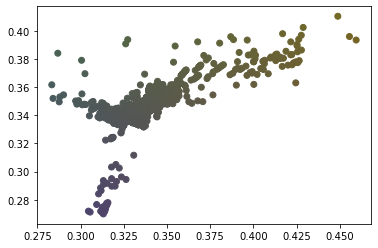

In [23]:
plt.scatter(rs,gs, c=color)

We identify a cluster in the lower left corner of the plot that we use to segment the image. We manually set the boundaries of the cluster, and extract a binary mask.

In [24]:
rmin = 0; rmax = 0.35; gmin = 0; gmax = 0.325; bmin = 0; bmax = 1

In [25]:
mask = cv2.inRange(img3n, (rmin, gmin, bmin), (rmax, gmax, bmax))

(-0.5, 639.5, 479.5, -0.5)

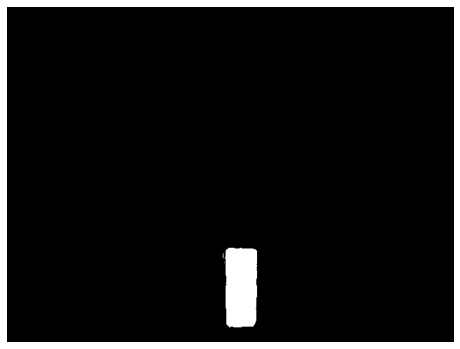

In [26]:
plt.figure(figsize=(8,8))
plt.imshow(mask, cmap='gray')
plt.axis('off')

Then we specify another cluster that is in the right side of the plot. The corresponding binary mask is shown below.

In [27]:
rmin = 0.375; rmax = 1; gmin = 0; gmax = 1; bmin = 0; bmax = 1

In [28]:
mask2 = cv2.inRange(img3n, (rmin, gmin, bmin), (rmax, gmax, bmax))

(-0.5, 639.5, 479.5, -0.5)

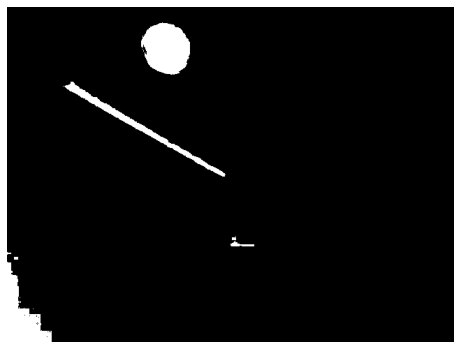

In [29]:
plt.figure(figsize=(8,8))
plt.imshow(mask2, cmap='gray')
plt.axis('off')

To segment the bright objects, we use thresholding of the grayscale image.

In [30]:
ret3,thresh3 = cv2.threshold(gray3,188,255,cv2.THRESH_BINARY)

(-0.5, 639.5, 479.5, -0.5)

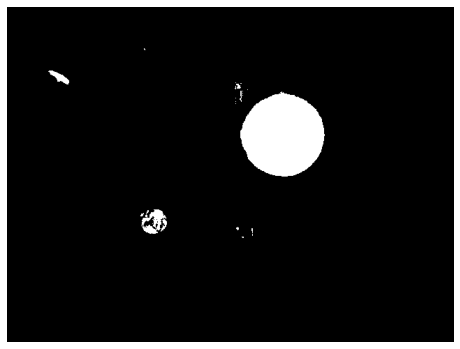

In [31]:
plt.figure(figsize=(8,8))
plt.imshow(thresh3, cmap='gray')
plt.axis('off')

Finally, we combine the three masks to obtain the segmented image.

In [32]:
seg = mask+mask2+thresh3

(-0.5, 639.5, 479.5, -0.5)

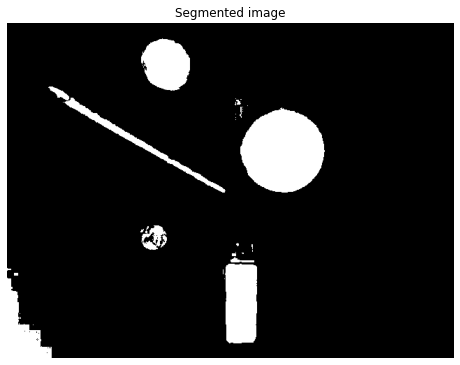

In [33]:
plt.figure(figsize=(8,8))
plt.imshow(seg, cmap='gray')
plt.title('Segmented image')
plt.axis('off')

The segmentation result is now reasonable, but there is still space for improvement. One way of improving the segmentation result is to use postprocessing.

## Binary morphology

Binary morphology is a common approach for filtering the segmentation result. Morphological closing can be used to fill gaps and holes, and morphological opening enables removing small isolated objects that are often caused by noise. Structuring element defines the shape and size of the filter.

Next we use a circular structuring element with the diameter of 9 pixels to perform closing to the segmentation result obtained in the previous section.

In [34]:
sel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))

In [35]:
closing = cv2.morphologyEx(seg, cv2.MORPH_CLOSE, sel1)

(-0.5, 639.5, 479.5, -0.5)

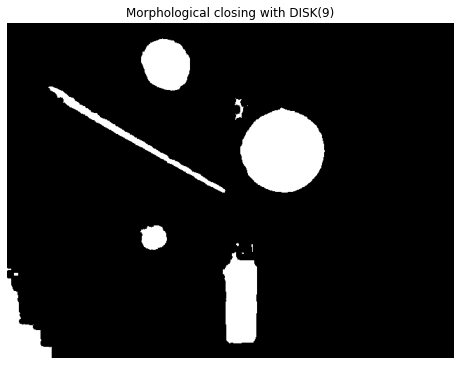

In [36]:
plt.figure(figsize=(8,8))
plt.imshow(closing, cmap='gray')
plt.title('Morphological closing with DISK(9)')
plt.axis('off')

Then, we perform opening to the previous result using a circular structuring element with the diameter of 7 pixels.

In [37]:
sel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))

In [38]:
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, sel2)

(-0.5, 639.5, 479.5, -0.5)

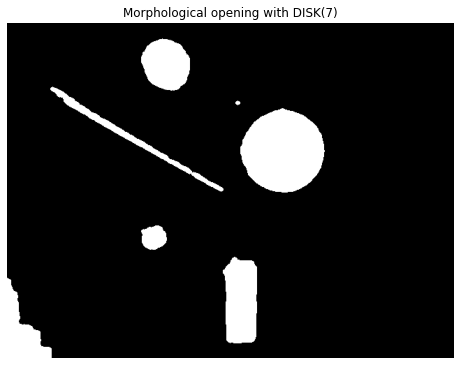

In [39]:
plt.figure(figsize=(8,8))
plt.imshow(opening, cmap='gray')
plt.title('Morphological opening with DISK(7)')
plt.axis('off')

In the resulting binary image there are 7 objects from which 5 are actual objects and 2 are spurious.

## Connected component labeling

Connected component labeling gives a unique label to each connected component in the binary image. It allows us to extract separate components and calculate shape features to characterize the objects.

In [40]:
ret, labels = cv2.connectedComponents(opening)

(-0.5, 639.5, 479.5, -0.5)

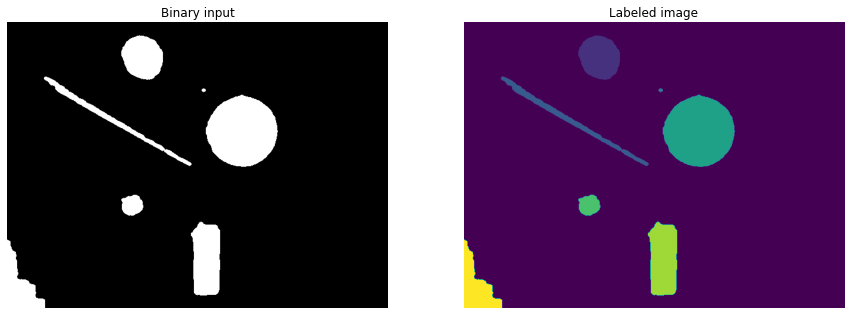

In [41]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(opening, cmap='gray')
plt.title('Binary input')
plt.axis('off')
plt.subplot(122)
plt.imshow(labels)
plt.title('Labeled image')
plt.axis('off')

Here are the masks for the background and the individual 7 objects.

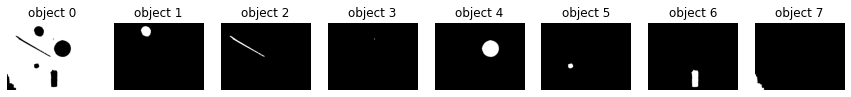

In [42]:
plt.figure(figsize=(15,5))
for i in range(ret):
    plt.subplot(1,ret,i+1)
    plt.imshow(labels==i, cmap='gray')
    plt.title('object '+str(i))
    plt.axis('off')

Next, we extract and plot their contours that is the closed sequence of pixels circumfering the objects.

In [43]:
cnt,_ = cv2.findContours(opening, 1, 1)

(-22.700000000000003, 476.7, 501.85, -0.8500000000000014)

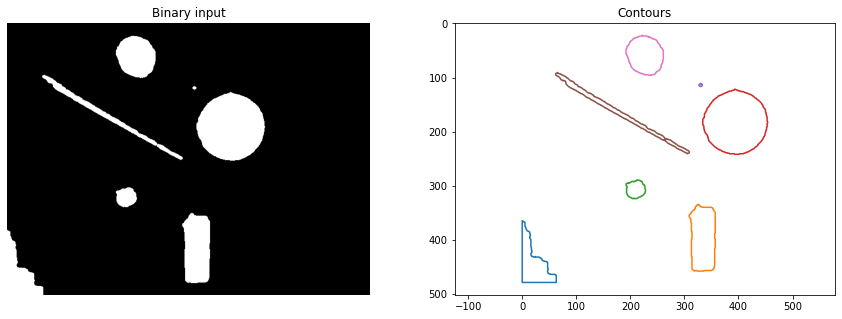

In [44]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(opening, cmap='gray')
plt.title('Binary input')
plt.axis('off')
plt.subplot(122)
for i in range(len(cnt)):
    plt.plot(cnt[i][:,0,0],cnt[i][:,0,1])
plt.gca().invert_yaxis()
plt.title('Contours')
plt.axis('equal')

We also print a table that shows some basic shape features (area, centroid, perimeter length, complexity).

In [45]:
print('Obj.  Area     cX   cY   Perim. Compl.')
print('--------------------------------------')
for i in range(len(cnt)):
    area = cv2.contourArea(cnt[i])
    M = cv2.moments(cnt[i])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    perimeter = cv2.arcLength(cnt[i],True)
    complexity = perimeter**2 / area
    print('{:4d} {:8.1f} {:4.0f} {:4.0f} {:6.1f} {:7.2f}'.format(i, area, cX, cY, perimeter, complexity))

Obj.  Area     cX   cY   Perim. Compl.
--------------------------------------
   0   3238.0   21  443  341.7   36.07
   1   5051.5  334  397  321.6   20.48
   2    943.5  209  307  122.8   15.99
   3  10841.5  394  183  393.9   14.31
   4     24.0  330  114   19.3   15.54
   5   2124.5  172  161  629.5  186.55
   6   3869.0  227   58  241.6   15.09


Finally, we approximate the objects with ellipses and overlay them on the original image.

In [46]:
image = img3.copy()
for c in cnt:
    ellipse = cv2.fitEllipse(c)
    cv2.ellipse(image,ellipse,(0,255,0),2)

(-0.5, 639.5, 479.5, -0.5)

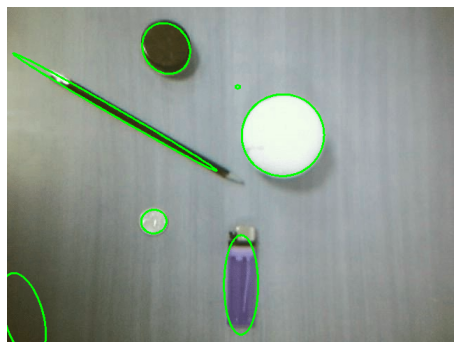

In [47]:
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis('off')